In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2

In [2]:
import os

def Classes_Count(path, name):
    Classes_Dict = {}
    for Class in os.listdir(path):
        Full_Path = os.path.join(path, Class)
        Classes_Dict[Class] = len(os.listdir(Full_Path))
    df = pd.DataFrame(Classes_Dict, index=[name])
    return df

In [3]:
# Verisetinin konumları
train_dir = rf'{os.getcwd()}{os.sep}archive{os.sep}train'
test_dir = rf'{os.getcwd()}{os.sep}archive{os.sep}test'

In [4]:

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)
pd.concat([Train_Count, Test_Count], axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


In [5]:
img_width,img_height=224,224
batch_size=32
epochs=100
num_classes=7

In [6]:
data_generator = ImageDataGenerator(
    rescale=1./255,  #  [0, 255] den [0, 1] arasına indirmek için
    rotation_range=40,  # Rastgele resmi döndürme
    width_shift_range=0.2,  # Genişlik kaydırma aralığı
    height_shift_range=0.2,  # Yükseklik kaydırma aralığı
    shear_range=0.2,  # Kesme aralığı
    zoom_range=0.2,  # Yakınlaştırma aralığı
    horizontal_flip=True,  # Yatay çevirme
    fill_mode='nearest',  # Oluşan yeni pixelleri doldurma yöntemi
    validation_split=0.2  # verilerin %20 doğrulama için kullanılacak
)

In [7]:
test_data_generator=ImageDataGenerator(rescale=1./255,validation_split=0.2) # tensorflow keras kütüphanesindeki ImageDataGenerator

train_generator=data_generator.flow_from_directory(
train_dir,
target_size=(img_width,img_height),
batch_size=batch_size,
class_mode='categorical',
color_mode='rgb',
subset='training')

validation_generator=data_generator.flow_from_directory(
train_dir,
target_size=(img_width,img_height),
batch_size=batch_size,
class_mode='categorical',
color_mode='rgb',
subset='validation')

test_generator=test_data_generator.flow_from_directory(
test_dir,
target_size=(img_width,img_height),
batch_size=batch_size,
class_mode='categorical',
color_mode='rgb')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
# Pre-trained ResNet50V2 modelini yüklüyoruz
ResNet50V2_base = ResNet50V2(input_shape=(img_width, img_height, 3),
                             include_top=False,
                             weights='imagenet'
                             )

#  Son 50 katman harici tüm katmanları dondur
ResNet50V2_base.trainable = True
for layer in ResNet50V2_base.layers[:-50]:
    layer.trainable = False

def Create_Custom_ResNet50V2_Model():
    model = Sequential([
        ResNet50V2_base,
        Dropout(0.25), # overfitting engellemek icin
        BatchNormalization(), # overfitting engellemek icin
        Flatten(), # Resnetten çıkan sonucu uygun hale getirme
        Dense(64, activation='relu'), 
        BatchNormalization(),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])
    return model

ResNet50V2_Model = Create_Custom_ResNet50V2_Model()
ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Callbacks
checkpoint_path = "ResNet50V2_Model_Checkpoint.keras"
Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)
Early_Stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1)
Reducing_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

In [10]:
ResNet50V2_history = ResNet50V2_Model.fit(train_generator, validation_data=validation_generator, epochs=epochs, batch_size=batch_size,
                                           callbacks=callbacks, steps_per_epoch=steps_per_epoch,
                                           validation_steps=validation_steps)

Epoch 1/100
717/717 [==============================] - 232s 314ms/step - loss: 1.9113 - accuracy: 0.3202 - val_loss: 2.1961 - val_accuracy: 0.3650 - lr: 0.0010
Epoch 2/100
717/717 [==============================] - 222s 309ms/step - loss: 1.6130 - accuracy: 0.4033 - val_loss: 1.5773 - val_accuracy: 0.4368 - lr: 0.0010
Epoch 3/100
717/717 [==============================] - 223s 311ms/step - loss: 1.4624 - accuracy: 0.4493 - val_loss: 1.4902 - val_accuracy: 0.4591 - lr: 0.0010
Epoch 4/100
717/717 [==============================] - 222s 310ms/step - loss: 1.3807 - accuracy: 0.4791 - val_loss: 1.3401 - val_accuracy: 0.5054 - lr: 0.0010
Epoch 5/100
717/717 [==============================] - 223s 311ms/step - loss: 1.3420 - accuracy: 0.4928 - val_loss: 1.7935 - val_accuracy: 0.4838 - lr: 0.0010
Epoch 6/100
717/717 [==============================] - 221s 309ms/step - loss: 1.3372 - accuracy: 0.4994 - val_loss: 1.2837 - val_accuracy: 0.5257 - lr: 0.0010
Epoch 7/100
717/717 [===================

In [11]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_generator)
print("Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

225/225 [==============================] - 16s 72ms/step - loss: 0.9896 - accuracy: 0.6284
Test Loss: 0.98959
Test Accuracy: 62.84%


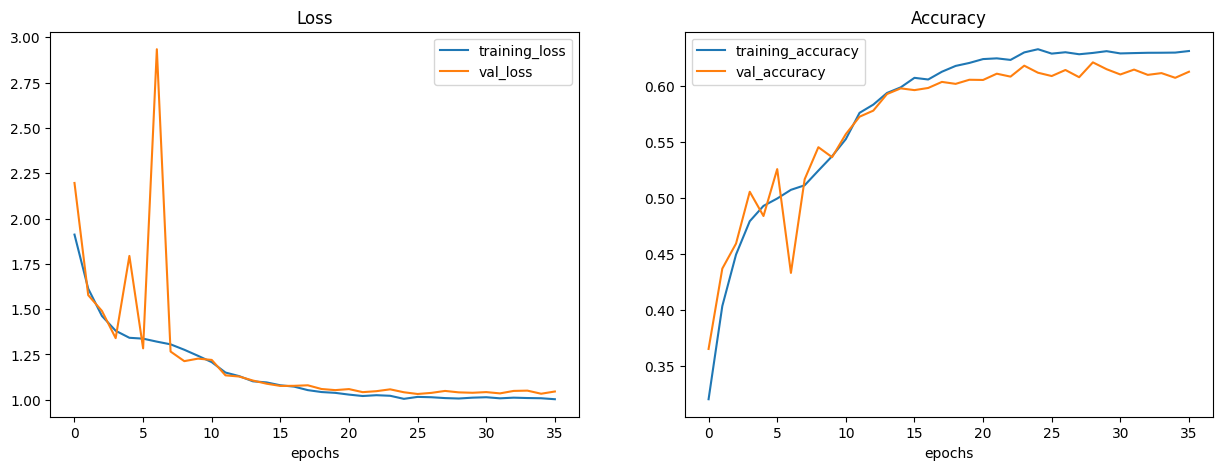

In [12]:
import matplotlib.pyplot as plt


def plot_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

plot_curves(ResNet50V2_history)

In [13]:
ResNet50V2_Model.to_json()
ResNet50V2_Model.save("ResNet50V2_Model_2.h5")
ResNet50V2_Model.save_weights("ResNet50V2_Model_Weights_2.h5")
